In [41]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

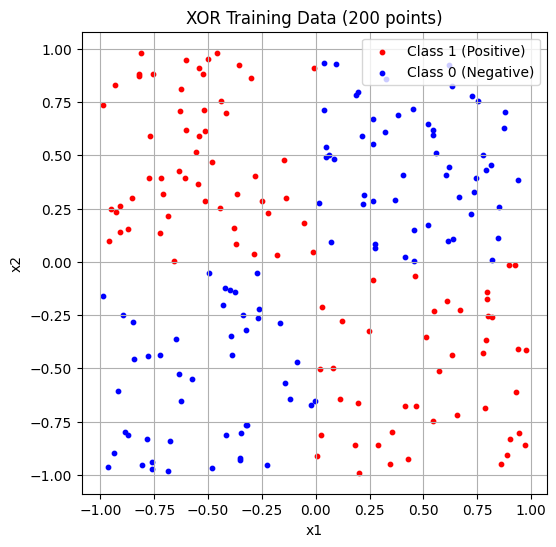

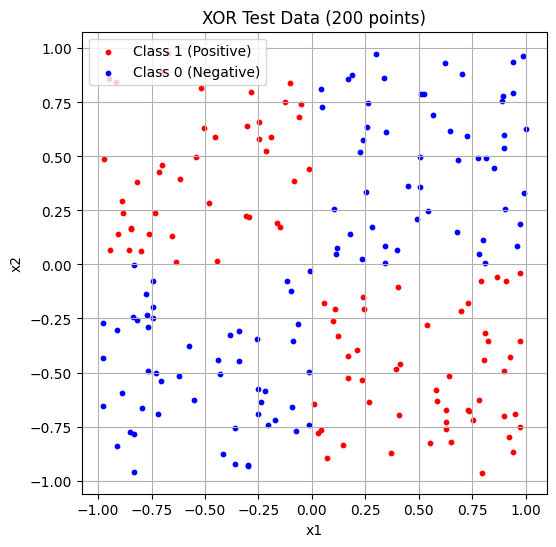

In [42]:
np.random.seed(42)

def generate_xor_data(n_points, x_range=(-1, 1)):
    x1 = np.random.uniform(x_range[0], x_range[1], n_points)
    x2 = np.random.uniform(x_range[0], x_range[1], n_points)

    labels = np.where(x1 * x2 < 0, 1, 0)

    return np.column_stack((x1, x2)), labels

n_train, n_test = 200, 200
train_data, train_labels = generate_xor_data(n_train, x_range=(-1, 1))
test_data, test_labels = generate_xor_data(n_test, x_range=(-1, 1))

def plot_xor_data(data, labels, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], color='r', label='Class 1 (Positive)', s=10)
    plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], color='b', label='Class 0 (Negative)', s=10)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_xor_data(train_data, train_labels, "XOR Training Data (200 points)")
plot_xor_data(test_data, test_labels, "XOR Test Data (200 points)")


In [43]:
def plot_decision_surface(model, data, labels, title):
    x_min, x_max =  - 1.5, + 1.5
    y_min, y_max =  - 1.5, + 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    grid = np.c_[xx.ravel(), yy.ravel()] #flattening and then concatenating
    with torch.no_grad():
        grid_tensor = torch.FloatTensor(grid)
        predictions = model(grid_tensor)
        predictions = torch.argmax(predictions, dim=1).numpy() #predictionc are in a 1D array

    predictions = predictions.reshape(xx.shape) #reshaping to a 2D array
    plt.contourf(xx, yy, predictions, alpha=0.8)
    plt.scatter(data[:, 0], data[:, 1], c=labels, edgecolor='k', marker='o')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

In [45]:
def calculate_accuracy(model, data_tensor, labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(data_tensor)
        _, predicted = torch.max(outputs, 1) # _ carries the max vaalue, which is not needed
        correct = (predicted == labels_tensor).sum().item()
        accuracy = correct / labels_tensor.size(0) * 100
    return accuracy

## MLP

Epoch [100/1000], Loss: 0.2261, Train Accuracy: 90.50%, Test Accuracy: 89.50%
Epoch [200/1000], Loss: 0.1172, Train Accuracy: 96.50%, Test Accuracy: 97.50%
Epoch [300/1000], Loss: 0.0689, Train Accuracy: 98.50%, Test Accuracy: 98.00%
Epoch [400/1000], Loss: 0.0534, Train Accuracy: 99.50%, Test Accuracy: 98.00%
Epoch [500/1000], Loss: 0.0440, Train Accuracy: 99.50%, Test Accuracy: 98.00%
Epoch [600/1000], Loss: 0.0372, Train Accuracy: 99.50%, Test Accuracy: 98.50%
Epoch [700/1000], Loss: 0.0319, Train Accuracy: 99.50%, Test Accuracy: 98.50%
Epoch [800/1000], Loss: 0.0277, Train Accuracy: 99.50%, Test Accuracy: 98.50%
Epoch [900/1000], Loss: 0.0241, Train Accuracy: 100.00%, Test Accuracy: 98.50%
Epoch [1000/1000], Loss: 0.0212, Train Accuracy: 100.00%, Test Accuracy: 98.50%
Final Test Accuracy: 98.50%


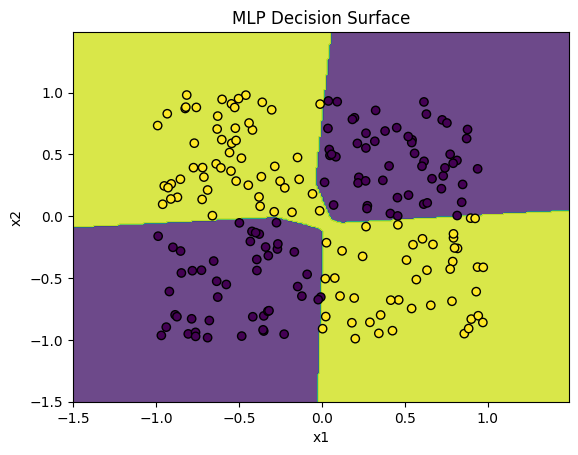

In [46]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

train_data_tensor = torch.FloatTensor(train_data) #numpy to torch
train_labels_tensor = torch.LongTensor(train_labels)
test_data_tensor = torch.FloatTensor(test_data)
test_labels_tensor = torch.LongTensor(test_labels)


input_size = 2
hidden_size = 10
output_size = 2

model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 1000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(train_data_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0: #non-programming indexing
        test_accuracy = calculate_accuracy(model, test_data_tensor, test_labels_tensor)
        train_accuracy = calculate_accuracy(model, train_data_tensor, train_labels_tensor)
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

final_test_accuracy = calculate_accuracy(model, test_data_tensor, test_labels_tensor)
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')


plot_decision_surface(model, train_data, train_labels, "MLP Decision Surface")

## L1

In [47]:
from sklearn.model_selection import train_test_split

train_data_train, train_data_val, train_labels_train, train_labels_val = train_test_split(
    train_data_tensor, train_labels_tensor, test_size=0.2, random_state=42
)


In [48]:
def l1_regularization(model, lambda_l1):
    l1_norm = sum(param.abs().sum() for param in model.parameters())
    return lambda_l1 * l1_norm

def train_with_ln(model, train_data, train_labels, val_data, val_labels, lambd, whichln, n_epochs=1000):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_data)
        if whichln == 1:
          loss = criterion(outputs, train_labels) + l1_regularization(model, lambd)
        elif whichln == 2:
          loss = criterion(outputs, train_labels) + l2_regularization(model, lambd)
        else:
          loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_data)
            if whichln == 1:
              val_loss = criterion(val_outputs, val_labels) + l1_regularization(model, lambd)
            elif whichln == 2:
              val_loss = criterion(val_outputs, val_labels) + l2_regularization(model, lambd)
            else:
              val_loss = criterion(val_outputs, val_labels)

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model = model.state_dict() #a dictionary containing the model's parameters

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')


    model.load_state_dict(best_model)
    return model


In [49]:
l1_penalties = [0.00001, 0.0001, 0.001, 0.01, 0.1]
best_lambda_1= None
best_model_1 = None
best_val_loss = float('inf')

for lambda_l1 in l1_penalties:
    print(f'Training with L1 penalty = {lambda_l1}')

    model = MLP(input_size, hidden_size, output_size)
    trained_model = train_with_ln(model, train_data_train, train_labels_train, train_data_val, train_labels_val, lambda_l1,1)

    with torch.no_grad():
        val_outputs = trained_model(train_data_val)
        val_loss = criterion(val_outputs, train_labels_val) + l1_regularization(trained_model, lambda_l1)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_lambda_1 = lambda_l1
        best_model_1 = trained_model

print(f'Best L1 penalty coefficient: {best_lambda_1}')


Training with L1 penalty = 1e-05
Epoch [100/1000], Training Loss: 0.1531, Validation Loss: 0.2000
Epoch [200/1000], Training Loss: 0.0784, Validation Loss: 0.1110
Epoch [300/1000], Training Loss: 0.0568, Validation Loss: 0.0945
Epoch [400/1000], Training Loss: 0.0446, Validation Loss: 0.0900
Epoch [500/1000], Training Loss: 0.0362, Validation Loss: 0.0893
Epoch [600/1000], Training Loss: 0.0300, Validation Loss: 0.0902
Epoch [700/1000], Training Loss: 0.0251, Validation Loss: 0.0918
Epoch [800/1000], Training Loss: 0.0213, Validation Loss: 0.0941
Epoch [900/1000], Training Loss: 0.0182, Validation Loss: 0.0968
Epoch [1000/1000], Training Loss: 0.0158, Validation Loss: 0.0998
Training with L1 penalty = 0.0001
Epoch [100/1000], Training Loss: 0.1493, Validation Loss: 0.1419
Epoch [200/1000], Training Loss: 0.0849, Validation Loss: 0.1178
Epoch [300/1000], Training Loss: 0.0655, Validation Loss: 0.1059
Epoch [400/1000], Training Loss: 0.0547, Validation Loss: 0.1014
Epoch [500/1000], Trai

Final Test Accuracy: 99.00%


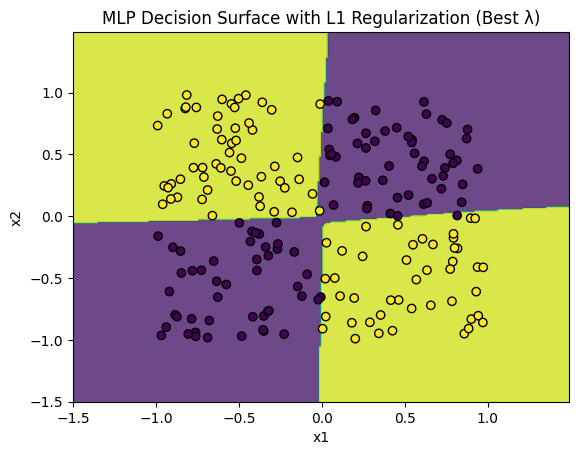

In [50]:
final_test_accuracy = calculate_accuracy(best_model_1, test_data_tensor, test_labels_tensor)
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

plot_decision_surface(best_model_1, train_data, train_labels, "MLP Decision Surface with L1 Regularization (Best λ)")

## L2

In [53]:
def l2_regularization(model, lambda_l2):
    l2_norm = sum(param.pow(2).sum() for param in model.parameters())
    return lambda_l2 * l2_norm

l2_penalties = [0.00001, 0.0001, 0.001, 0.01, 0.1]
best_lambda_2= None
best_model_2 = None
best_val_loss = float('inf')

for lambda_l2 in l2_penalties:
    print(f'Training with L2 penalty = {lambda_l2}')

    model = MLP(input_size, hidden_size, output_size)
    trained_model = train_with_ln(model, train_data_train, train_labels_train, train_data_val, train_labels_val, lambda_l2,2)

    with torch.no_grad():
        val_outputs = trained_model(train_data_val)
        val_loss = criterion(val_outputs, train_labels_val) + l2_regularization(trained_model, lambda_l2)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_lambda_2 = lambda_l2
        best_model_2 = trained_model

print(f'Best L2 penalty coefficient: {best_lambda_2}')

Training with L2 penalty = 1e-05
Epoch [100/1000], Training Loss: 0.1449, Validation Loss: 0.1612
Epoch [200/1000], Training Loss: 0.0763, Validation Loss: 0.1204
Epoch [300/1000], Training Loss: 0.0567, Validation Loss: 0.1059
Epoch [400/1000], Training Loss: 0.0450, Validation Loss: 0.1011
Epoch [500/1000], Training Loss: 0.0369, Validation Loss: 0.1009
Epoch [600/1000], Training Loss: 0.0309, Validation Loss: 0.1030
Epoch [700/1000], Training Loss: 0.0263, Validation Loss: 0.1063
Epoch [800/1000], Training Loss: 0.0228, Validation Loss: 0.1103
Epoch [900/1000], Training Loss: 0.0201, Validation Loss: 0.1147
Epoch [1000/1000], Training Loss: 0.0180, Validation Loss: 0.1196
Training with L2 penalty = 0.0001
Epoch [100/1000], Training Loss: 0.1592, Validation Loss: 0.2750
Epoch [200/1000], Training Loss: 0.0882, Validation Loss: 0.1385
Epoch [300/1000], Training Loss: 0.0659, Validation Loss: 0.1168
Epoch [400/1000], Training Loss: 0.0579, Validation Loss: 0.1143
Epoch [500/1000], Trai

Final Test Accuracy: 99.00%


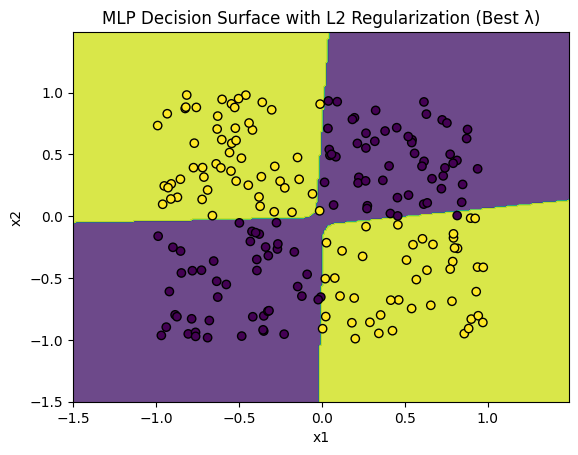

In [54]:
final_test_accuracy = calculate_accuracy(best_model_2, test_data_tensor, test_labels_tensor)
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

plot_decision_surface(best_model_2, train_data, train_labels, "MLP Decision Surface with L2 Regularization (Best λ)")

## Logistic


Epoch [500/10000], Loss: 0.2741, Test Accuracy: 92.00%
Epoch [1000/10000], Loss: 0.2034, Test Accuracy: 95.00%
Epoch [1500/10000], Loss: 0.1703, Test Accuracy: 96.00%
Epoch [2000/10000], Loss: 0.1495, Test Accuracy: 98.00%
Epoch [2500/10000], Loss: 0.1344, Test Accuracy: 98.00%
Epoch [3000/10000], Loss: 0.1224, Test Accuracy: 98.00%
Epoch [3500/10000], Loss: 0.1123, Test Accuracy: 98.00%
Epoch [4000/10000], Loss: 0.1037, Test Accuracy: 98.00%
Epoch [4500/10000], Loss: 0.0960, Test Accuracy: 98.50%
Epoch [5000/10000], Loss: 0.0892, Test Accuracy: 98.50%
Epoch [5500/10000], Loss: 0.0830, Test Accuracy: 98.50%
Epoch [6000/10000], Loss: 0.0773, Test Accuracy: 98.50%
Epoch [6500/10000], Loss: 0.0722, Test Accuracy: 98.50%
Epoch [7000/10000], Loss: 0.0674, Test Accuracy: 99.00%
Epoch [7500/10000], Loss: 0.0630, Test Accuracy: 99.50%
Epoch [8000/10000], Loss: 0.0589, Test Accuracy: 99.50%
Epoch [8500/10000], Loss: 0.0551, Test Accuracy: 99.50%
Epoch [9000/10000], Loss: 0.0516, Test Accuracy: 

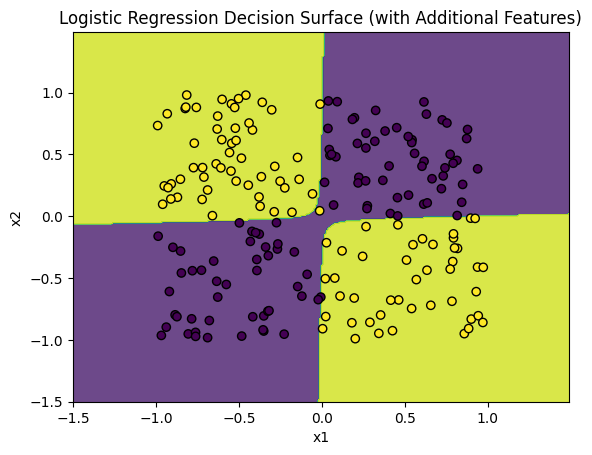

In [55]:
def add_polynomial_features(data):
    x1 = data[:, 0]
    x2 = data[:, 1]
    x1_x2 = x1 * x2
    x1_square = x1 ** 2
    x2_square = x2 ** 2
    return np.column_stack((x1, x2, x1_x2, x1_square, x2_square))

train_data_poly = add_polynomial_features(train_data)
test_data_poly = add_polynomial_features(test_data)

train_data_tensor = torch.FloatTensor(train_data_poly)
train_labels_tensor = torch.LongTensor(train_labels)
test_data_tensor = torch.FloatTensor(test_data_poly)
test_labels_tensor = torch.LongTensor(test_labels)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

input_size = train_data_poly.shape[1] # here, 5
output_size = 2
model = LogisticRegressionModel(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 10000
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_data_tensor)
    loss = criterion(outputs, train_labels_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        with torch.no_grad():
            test_outputs = model(test_data_tensor)
            _, predicted = torch.max(test_outputs, 1)
            test_accuracy = (predicted == test_labels_tensor).float().mean().item() * 100
            print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {test_accuracy:.2f}%')

def plot_decision_surface(model, data, labels, title):
    x_min, x_max = -1.5, 1.5
    y_min, y_max = -1.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_poly = add_polynomial_features(grid)

    with torch.no_grad():
        grid_tensor = torch.FloatTensor(grid_poly)
        predictions = model(grid_tensor)
        predictions = torch.argmax(predictions, dim=1).numpy()

    predictions = predictions.reshape(xx.shape)
    plt.contourf(xx, yy, predictions, alpha=0.8)
    plt.scatter(data[:, 0], data[:, 1], c=labels, edgecolor='k', marker='o')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

plot_decision_surface(model, train_data, train_labels, "Logistic Regression Decision Surface (with Additional Features)")


# Observations
1. Without regularisation, the MLP model formed is overfitted on the training dataset, which can be seen by the shape of decision boundary
2. With L1 regularisatioon, we see that the decision boundary is not overfitting the training dataset. Without the regularisation, the test accuracy was 98.5%. Now it is 99%.
3. Also now the decision boundary seems more linear, maybe because of the sparcity introduced by L1 regularisation ehich sets a lot of parameters to nearly zero.
4. With L2 regularisation, overfitting is handeled well with better test accuracy just like L1 regularisation. 
5. But unlike the decision boundary of L1 regularisation, the decision boundary is smoother which can be seen by boundary near the origin.
6. Using logistic regression we got a very well-trained model with a very smooth boundary because of the addition of hand-crafted features. 
7. The decision boundary is smooth because it is a polynomial(with degree 2)
